In [5]:
%pip install easyocr

  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
  Using cached torch-2.10.0-cp312-cp312-win_amd64.whl.metadata (31 kB)
  Using cached torchvision-0.25.0-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached opencv_python_headless-4.13.0.90-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached scipy-1.17.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached numpy-2.4.1-cp312-cp312-win_amd64.whl.metadata (6.6 kB)
  Using cached scikit_image-0.26.0-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached python_bidi-0.6.7-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
  Using cached shapely-2.1.2-cp312-cp312-win_amd64.whl.metadata (7.1 kB)
  Using cached pyclipper-1.4.0-cp312-cp312-win_amd64.whl.metadata (8.8 kB)
  Using cached ninja-1.13.0-py3-none-win_amd64.whl.metadata (5.1 kB)
  Using cached filelock-3.20.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from typing import TypedDict
import os
import cv2
import easyocr
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END

# --------- CONFIG ---------
os.environ["OPENROUTER_API_KEY"] = "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"

llm = ChatOpenAI(
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1",
    model="gpt-3.5-turbo"
)

reader = easyocr.Reader(['en'])

# --------- IMAGE PREPROCESSING ---------
def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    img = cv2.GaussianBlur(img, (5,5), 0)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img

# --------- STATE ---------
class EvalState(TypedDict):
    image_path: str
    extracted_text: str
    evaluation: str

# --------- NODES ---------
def ocr_node(state: EvalState):
    img = preprocess_image(state["image_path"])
    text = reader.readtext(img, detail=0)
    return {"extracted_text": " ".join(text)}

def cleanup_node(state: EvalState):
    prompt = f"""
Fix OCR errors in this handwritten exam answer.
Correct spelling, chemical notation, and grammar.
Do NOT add new information.

OCR Text:
{state['extracted_text']}

Cleaned Text:
"""
    response = llm.invoke(prompt)
    return {"extracted_text": response.content.strip()}

def evaluation_node(state: EvalState):
    prompt = f"""
You are an exam evaluator.

Question:
Explain photosynthesis.

Model Answer:
Photosynthesis is the process by which plants use sunlight to convert
carbon dioxide and water into glucose and oxygen.

Student Answer:
{state['extracted_text']}

Return:
- Score out of 5
- Short feedback
"""
    response = llm.invoke(prompt)
    return {"evaluation": response.content.strip()}

# --------- GRAPH ---------
graph = StateGraph(EvalState)

graph.add_node("ocr", ocr_node)
graph.add_node("cleanup", cleanup_node)
graph.add_node("evaluate", evaluation_node)

graph.set_entry_point("ocr")
graph.add_edge("ocr", "cleanup")
graph.add_edge("cleanup", "evaluate")
graph.add_edge("evaluate", END)

app = graph.compile()

# --------- RUN ---------
if __name__ == "__main__":
    result = app.invoke({
        "image_path": "answer.jpg"   # <-- replace with your image
    })

    print("\n--- EXTRACTED TEXT ---")
    print(result["extracted_text"])

    print("\n--- EVALUATION ---")
    print(result["evaluation"])


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



--- EXTRACTED TEXT ---
Photosynthesis is the process of converting inorganic substances (carbon dioxide and water) into organic food (glucose) by plants with the help of sunlight and chlorophyll.

--- EVALUATION ---
Score: 4/5

Feedback: 
Good job on explaining the process of photosynthesis. Make sure to mention the production of oxygen as a byproduct of photosynthesis in your explanation for a more comprehensive answer. Keep up the good work!


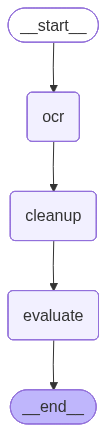

In [7]:
app